# 前処理の威力 breast_cancer編
## このNotebookのねらい
- 前処理の効果を理解する
    - Scaling
    - PCA


## このNotebookで重要じゃないこと
- 〇〇

In [1]:
import warnings

import seaborn as sns

warnings.filterwarnings('ignore')

%precision 3
%matplotlib inline

# データの準備

In [2]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

# 交差検証を使ったパラメータチューニングのワークフローのおさらい


<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=480>

# 評価プロトコル
- データ分割
- StratifiedKFold

In [3]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          train_size=0.75, random_state=0)

In [4]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=0)

# SVMで4パターンのモデル構築
1. 前処理なしのSVM
2. PCAのみ適用
3. Scalingのみ適用
4. ScalingとPCAの順で適用

## 前処理なしの場合

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

params_svc = {
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

gs_svc = GridSearchCV(estimator=SVC(),
                      param_grid=params_svc,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=skf)

In [6]:
# 学習
gs_svc.fit(X_trainval, y_trainval)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [7]:
print(gs_svc.best_params_)
print(gs_svc.best_score_)
print(gs_svc.score(X_test, y_test))

{'C': 1, 'gamma': 0.001}
0.9225352112676056
0.9300699300699301


## PCAのみ適用
- 主成分分析による次元削減

In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('svm', SVC()),
])

param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
}
gs_pipe_pca = GridSearchCV(pipe,
                           param_grid_pipe,
                           cv=skf,
                           scoring='accuracy',
                           n_jobs=-1)

gs_pipe_pca.fit(X_trainval, y_trainval)
print(gs_pipe_pca.best_params_)
print(gs_pipe_pca.best_score_)
print(gs_pipe_pca.score(X_test, y_test))

{'svm__C': 1, 'svm__gamma': 0.001}
0.9272300469483568
0.9300699300699301


/Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Scalingのみ適用

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC()),
])

param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
}
gs_pipe_scaled = GridSearchCV(pipe,
                              param_grid_pipe,
                              cv=skf,
                              scoring='accuracy',
                              n_jobs=-1)

gs_pipe_scaled.fit(X_trainval, y_trainval)
print(gs_pipe_scaled.best_params_)
print(gs_pipe_scaled.best_score_)
print(gs_pipe_scaled.score(X_test, y_test))

{'svm__C': 1, 'svm__gamma': 1}
0.9812206572769953
0.972027972027972


## Scaling と PCA を適用

In [10]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=2)),
    ('svm', SVC()),
])

param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
}
gs_pipe_scaled_pca = GridSearchCV(pipe,
                                  param_grid_pipe,
                                  cv=skf,
                                  scoring='accuracy',
                                  n_jobs=-1)

gs_pipe_scaled_pca.fit(X_trainval, y_trainval)
print(gs_pipe_scaled_pca.best_params_)
print(gs_pipe_scaled_pca.best_score_)
print(gs_pipe_scaled_pca.score(X_test, y_test))

{'svm__C': 10, 'svm__gamma': 0.1}
0.9460093896713615
0.9300699300699301


/Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# PCAの嬉しさと難しさ
- 教師なし学習の1つ
- 解釈の難しさ

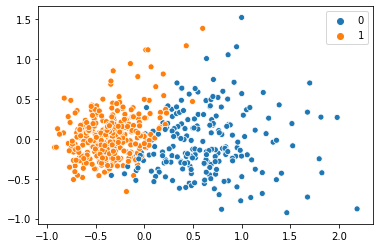

In [11]:
X_scaled = MinMaxScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y)

- 各成分(横軸と縦軸)が何なのかはよくわからないが、この2次元空有感では 良性(0) と 悪性(1) が区別できている

おわり